# <center> **Pap Smear Cells Classification**

Work Done By: **Eya Ghamgui**

## **Summary** 

1. Introduction
2. Target Data Retrieval
3. Original Images and Masks Retrieval
4. Hand Crafted Features 
5. Machine Learning Classification Models for the Binary Data 
6. Machine Learning Classification Models for the MultiClass Data
7. Prepare Images for Deep Learning Task
8. Deep Learning Classification Model for Binary Data
9. Deep Learning Classification Model for Multiclass Data
10. Conclusion



## **Set Path Environnement**

In [ ]:
# Import Functions.py
import sys
import os
import time

# Import drive content 
from google.colab import drive
drive.mount('/content/drive/')

# Start time 
startRun = time.time()

###########
########### PLEASE PUT THE ADEQUATE PATH "PathToFunctions" WHERE THE Functions.py EXISTS
###########
PathToFunctions = '/content/drive/MyDrive/Challange_Final/'
sys.path.append(PathToFunctions)
from Functions import *

###########
########### PLEASE CHANGE THE PATH WHERE THE Train AND Test FOLDERS AND metadataTrain and SampleSubmission FILES ARE SAVED
########### PLEASE CHANGE IT ADEQUATELY
###########
OriginalPath = '/content/drive/MyDrive/Challenge/'

# Create "Eya_Ghamgui" folder to save the masked images into the 
# adequate folders for further use in Deep Learning part
PathTo = OriginalPath + 'Eya_Ghamgui/'
if not os.path.exists(PathTo):
  os.mkdir(PathTo)

Mounted at /content/drive/


## **Import Libraries**

In [ ]:
# We need to install the library of the model
!pip install -U efficientnet

     |████████████████████████████████| 51kB 3.2MB/s 


In [ ]:
import warnings
import gc
import cv2 
import imageio
import numpy as np 
import pandas as pd
import seaborn as sns
from skimage import measure
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RF

import tensorflow as tf
from keras import backend as K
import efficientnet.keras as efn
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Flatten,Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout

## **Introduction**

Cervical cancer is one of the leading causes of cancer death in females worldwide. The disease can be cured if the patient is diagnosed in the pre-cancerous lesion stage or earlier. That is, accurate and timely cancer detection can save lives. A common physical examination technique widely used in the screening is Papanicolaou test or Pap test. This technique provides images of these cells for doctors to analyze. However, this method is very time consuming and prone to errors. Therefore, automatic and reliable cervical cancer detection methods can be devised through the accurate classification of Pap smear cell images.
<br><br>
In this project, we will work on the classification of these cells. We will start by exploring the dataset and then extract features. After that, we will perform several machine learning classification models.
<br><br> 

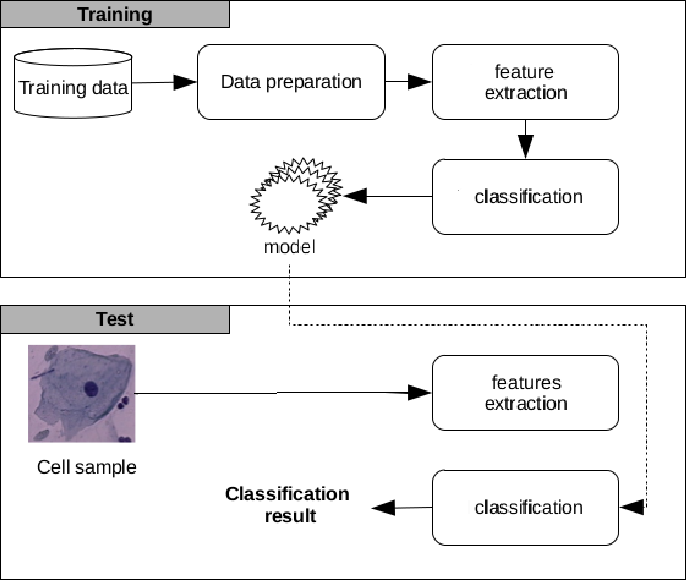

Finally, we will end up by improving the results with a deep learning model. All these methods are performed for both binary and multiclass classification.

## **Target Data Retrieval**

### 1. Read the Data 

In [ ]:
# Extract the CSV file 
Classes = pd.read_csv (OriginalPath + "metadataTrain.csv")

# Reindex the data
Classes = Classes.set_index('ID').sort_index()

# Show the data 
Classes.head()

,ABNORMAL,GROUP
ID,,
2,0,1
4,0,1
6,1,5
8,0,1
9,1,8


**Comment:**

**$~~\Longrightarrow$ This target dataset shows that we should work later on two problems: binary classification and multiclass classification.**

### 2. Shape of the data 

In [ ]:
# Print the shape of the data 
print('The number of rows = ' + str (Classes.shape[0]))
print('The number of columns = ' + str (Classes.shape[1]))

The number of rows = 2921
The number of columns = 2


**Comment:**

**$~~\Longrightarrow$ This train data contains 2921 images to train and fit the models.**

### 3. Data Exploration 

#### 3.1 Binary Data 

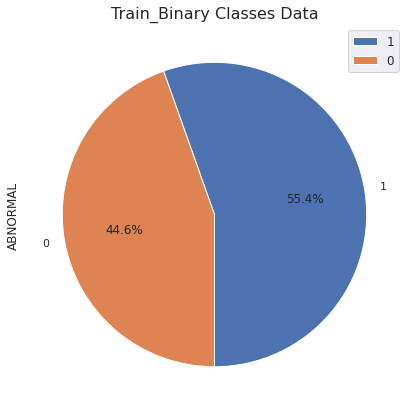

In [ ]:
# Plot the percentage of both categories
draw_pie(pd.DataFrame(Classes.ABNORMAL.value_counts()),'ABNORMAL','Train_Binary Classes Data')

#### 3.2 Multi-Class Data

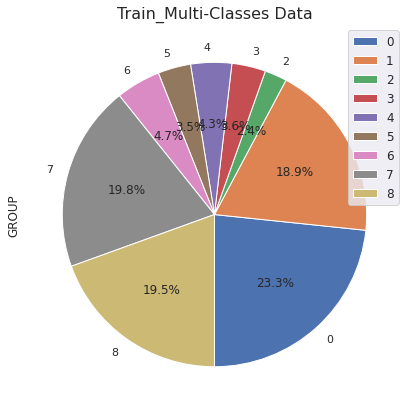

In [ ]:
# Plot the percentage of the different categories
draw_pie(pd.DataFrame(Classes.GROUP.value_counts()).sort_index(),'GROUP','Train_Multi-Classes Data')

#### 3.3 Interpretations: 

> - We notice that the binary dataset is balanced: $44.6\%$ for the class $0$ (Healthy) and $55.4\%$ for the class $1$ (Unhealthy). Therefore, we don't need any balancing method for the data.
<br><br> 
> - The multiclass dataset presents a data imbalance. Each of the classes $\{0,1,7,8\}$ has almost equal percentage of the data with the group of the classes $\{2,3,4,5,6\}$. That is, we need to take into consideration this data imbalance when performing different classification models. As a solution, we can add a bootstrap method to balance the data. 

## **Original Images and Masks Retrieval**

### 1. Read & Split the Data

In [ ]:
startTime = time.time()

n = None # Number of images to import, if None; then import all images

# Import images
names_Train, original_Train, segCyt_Train, segNuc_Train = ImportSaveImages(OriginalPath, PathTo, Classes, 'Train', n = n)
_, _, _, _ = ImportSaveImages(OriginalPath, PathTo, Classes, 'Test', n = n)
SetValPaths(PathTo)

endTime = time.time() - startTime
print('Runtime = ' , str(round(endTime, 3)) + ' seconds')

Runtime =  4273.718 seconds


### 2. Plot some Images 

#### 2.1 Binary Images

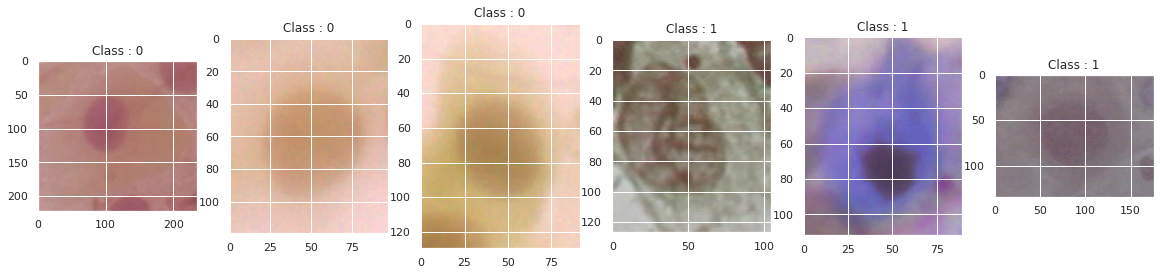

In [ ]:
plot_images(OriginalPath + 'Train/' , 3 , Classes , 'ABNORMAL' )

#### 2.2 MultiClass Images 

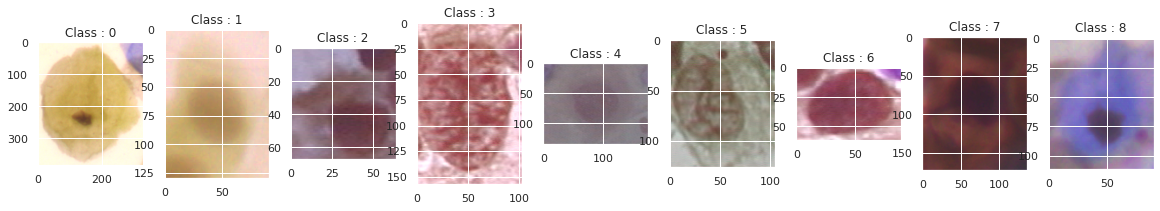

In [ ]:
plot_images(OriginalPath + 'Train/' ,  1 , Classes , 'GROUP' )

#### 2.3 Interpretations:

> - From the previous images, we notice that the healthy class presents a special patterns in the ROI such as the sphericity and the regularity of the cells. In addition, we remark that the nuclus is almost in the center of the cell and its shape is small when compared to the cytoplasm. However, the unhealthy class shows a non-regular shape of the cells and they may also do not have a nuclus. Some cell images contain a huge nuclus or a cytopplasm non distingable.  
<br><br> 
> - We can also remark that each image from the 9 classes has its own cracteristics. We notice that each one has a different shape or different position of nuclus in the cytoplasm. For example, in the third class, we cannot observe the difference between the nuclus and the cytoplasm.

## **Hand Crafted Features**

### 1. Feature Extraction

> **In this part, I tried to extract different features that represent relevent information in the images. These features are used later for the classification part.** 
<br><br> 
1. Average Intensity: the average intensity of the pixels for each channel and for each region (nucleus and cytoplasma).
<br><br>
2. The entropy: it is a measure of disorder or randomness, and hence a measure of uncertainty and it is determined approximately from the histogram of the image. In fact, the histogram shows the different grey level probabilities in the image. The entropy is calculated for each region from the image. 
<br><br>
3. Elongation: the ratio between the shortest and the longest diameter. It is calculated using the formula: $\frac{\lambda_{max}}{\lambda_{max}}$ of the eigenvalues of the main principal components in the ROI.
<br><br>
4. Compactness: it is a measure of how compact the shape of the cell is relative to a sphere.
<br><br>
5. N/C ratio: size of nucleus relative to cell size.
<br><br>
6. Distance between the center of nucleus and the center of cytoplasma: a measure of how well the nucleus is centered in the cytoplasm. The centers are calculated using the ratio between moments ($\bar{x} = \frac{M_{10}}{M_{00}} , \bar{y} = \frac{M_{01}}{M_{00}} $).
<br><br>
7. Orientation of cells: $\theta = \frac{1}{2} arctan(\frac{2 M_{11}}{M_{20}-M_{02}})$.

In [ ]:
# Extract Hand crafted features 
X , Y_binary , Y_Multi = GetFeatures(original_Train, segNuc_Train, segCyt_Train, names_Train, Classes, FeatType = 'HandCrafted')

/usr/local/lib/python3.7/dist-packages/skimage/measure/_moments.py:359: RuntimeWarning: invalid value encountered in true_divide
  / M[(0,) * image.ndim])  # weighted sum of all points
/content/drive/MyDrive/Challange_Final/Function.py:386: RuntimeWarning: divide by zero encountered in double_scalars
  f.append(mask1.sum() / mask0.sum())
/content/drive/MyDrive/Challange_Final/Function.py:423: RuntimeWarning: divide by zero encountered in double_scalars
  orient1 = (1/2) * np.arctan((2* m1[1,1])/(m1[2,0]-m1[0,2]))


### 2. Feature Exploration

#### 2.1 Rename the features 

In [ ]:
# List of names
list_of_features = {0 : 'avg_r_nuc',1 : 'avg_g_nuc',2 :'avg_b_nuc', 
                    3 : 'ent_r_nuc',4 : 'ent_g_nuc',5: 'ent_b_nuc', 
                    6 : 'el_r_nuc',7 : 'el_g_nuc',8 : 'el_b_nuc',
                    9 : 'co_r_nuc',10 :'co_g_nuc',11 :'co_b_nuc',
                    12 :'avg_r_cyt',13 :'avg_g_cyt',14 :'avg_b_cyt', 
                    15 :'ent_r_cyt',16 : 'ent_g_cyt',17 :'ent_b_cyt', 
                    18 : 'el_r_cyt',19:'el_g_cyt',20 : 'el_b_cyt',
                   21: 'co_r_cyt',22: 'co_g_cyt',23 : 'co_b_cyt',
                    24: 'N/C',25 : 'orient_nuc',26 :'dist',27 :'orient_cyt'}

# Rename Columns
X = X.set_axis(list_of_features.values(), axis='columns')

#### 2.2 Detect Correlated Features 

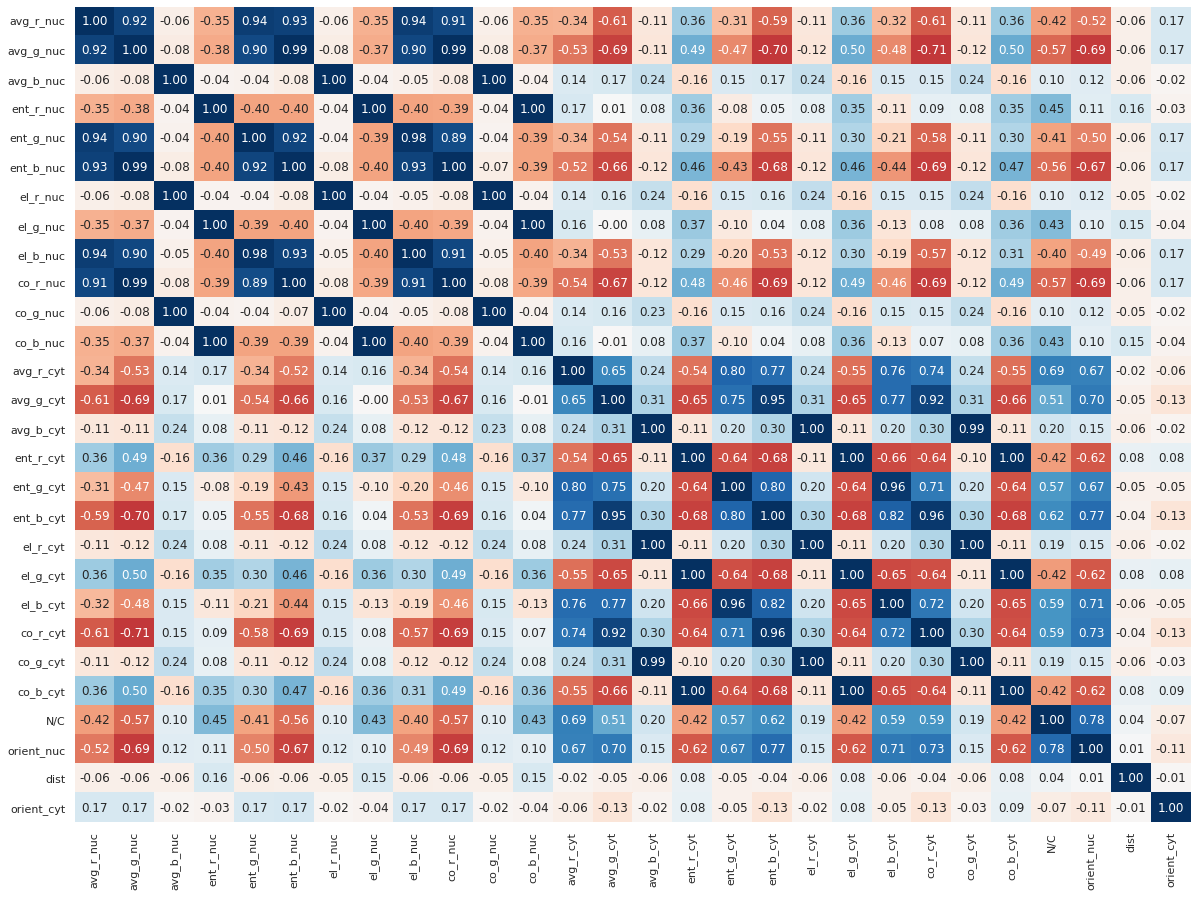

In [ ]:
# Correlation Matrix

plt.figure(figsize=(20,15))
sns.heatmap(X.corr(),annot=True , fmt = '.2f', cbar = False, cmap = 'RdBu', center = 0 );

**Interpretation:**

> - We can notice that some features like ['avg_r_nuc', 'avg_g_nuc', 'avg_b_nuc', 'ent_r_nuc', 'ent_g_nuc', 'ent_b_nuc', 'el_r_nuc', 'el_g_nuc', 'el_b_nuc', 'co_r_nuc', 'co_g_nuc', 'co_b_nuc'] and ['avg_r_cyt', 'avg_g_cyt', 'avg_b_cyt', 'ent_r_cyt', 'ent_g_cyt', 'ent_b_cyt', 'el_r_cyt', 'el_g_cyt', 'el_b_cyt', 'co_r_cyt', 'co_g_cyt', 'co_b_cyt', 'N/C', 'orient_nuc'] are highly correlated. I think these results are related to the fact that I calculated the same features for the different channels of the image. However, we can also remark that some features do not give the same information for different channels. 
<br><br>
> - Despite all the previous facts, the correlation may affect the models later, for that we have to apply the PCA algorithm, one of the helpful tools to reduce the data's variance and, it is used in exploratory data analysis and for making predictive models by creating new features that maximize the variance of the projected data.

### 3. PCA

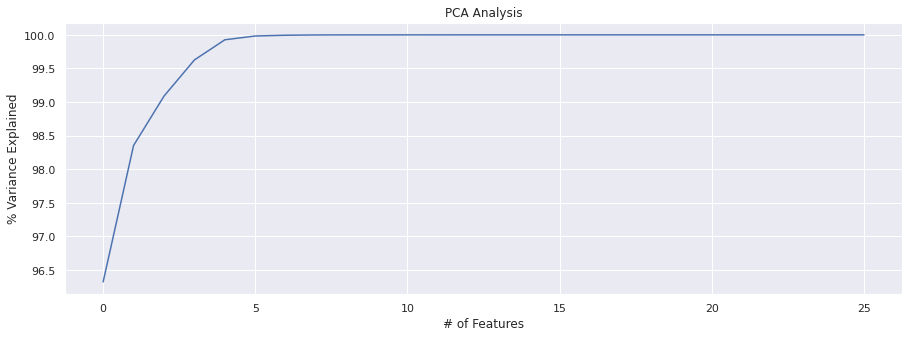

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Cumulative variance,96.323,98.353,99.088,99.627,99.927,99.983,99.994,99.999,99.999,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [ ]:
# Chosen features to apply the PCA
col1 = ['avg_r_nuc', 'avg_g_nuc', 'avg_b_nuc', 'ent_r_nuc', 'ent_g_nuc', 'ent_b_nuc', 'el_r_nuc', 'el_g_nuc', 'el_b_nuc', 'co_r_nuc', 'co_g_nuc', 'co_b_nuc',
        'avg_r_cyt', 'avg_g_cyt', 'avg_b_cyt', 'ent_r_cyt', 'ent_g_cyt', 'ent_b_cyt', 'el_r_cyt', 'el_g_cyt', 'el_b_cyt', 'co_r_cyt', 'co_g_cyt', 'co_b_cyt', 'N/C', 'orient_nuc']
        
df1 = X[col1]

# Determine the number of components 
pca = PCA()
pca.fit(df1)   
pca.explained_variance_ratio_ 
var=np.cumsum(pca.explained_variance_ratio_*100)

# Plot the cumulative variance 
plt.figure(figsize=(15,5))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.plot(np.arange(len(var)),var)
plt.show()

pd.DataFrame(np.round(var,3), columns=['Cumulative variance']).T

**Interpretation:**

> From the curve above, we can see clearly that the first 5 features gives us almost $100\% ~~(99.983\%)$ of variance explained in the data. Consequently, we chose the number of components equal to 5 as the best choice to work with.

In [ ]:
# Transform the data
pca = PCA(n_components = 5)
df1 = pca.fit_transform(df1)

X = X.drop(columns=col1)
col = ['pc1','pc2','pc3','pc4','pc5']
X = X.merge(pd.DataFrame(df1 ,index=X.index , columns=col),on=X.index).drop(columns=['key_0'])

### 4. Final Data 

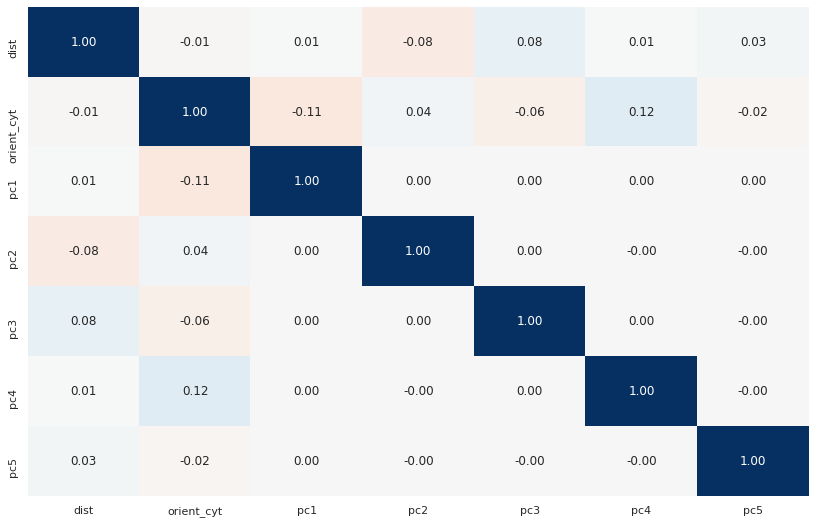

In [ ]:
# Correlation Matrix

plt.figure(figsize=(14,9))
sns.heatmap(X.corr(),annot=True,fmt = '.2f', cbar = False, cmap = 'RdBu', center = 0 );

**Interpretation:**

> We notice from the previous correlation matrix that all the features of the new dataset are not correlated. Thus, we can start the classification task. 

### 5. Split and Scale the Data  / Bootstrap Method for the MultiClass

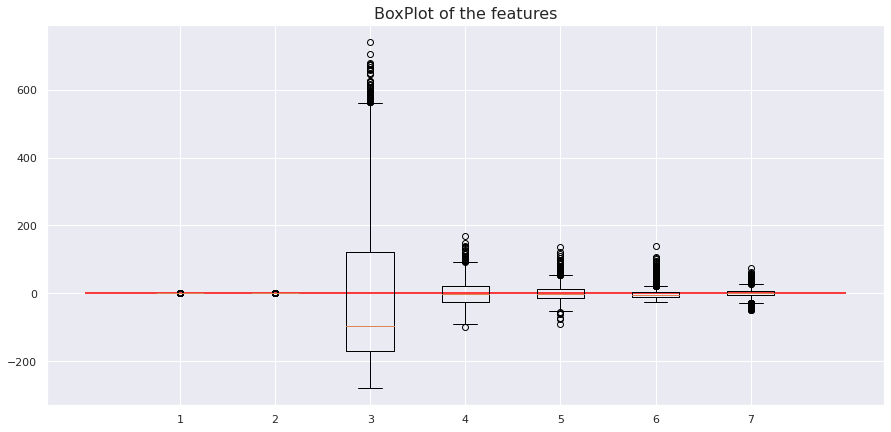

In [ ]:
# We need to decide whether we scale or noramalize the data. 

plt.figure(figsize=(15,7))
plt.boxplot(np.array(X))
plt.hlines(0,0,8,color ="red") 
plt.title('BoxPlot of the features', fontsize=16)
plt.show()

**Comment:** 

$\Rightarrow$ According to the previous BoxPlot, we notice that the features  have both negative and positive values. Thus, they should be standardized. 

In [ ]:
# Split and Scale using the TrainTestSplit function for the binary dataset
X_train_b, X_test_b, y_train_b, y_test_b = TrainTestSplit(X, Y_binary, scale = True, test_size = 0.25, random_state=0)

In [ ]:
# Split and Scale using the TrainTestSplit function for MultiClass dataset with the bootstrap method
X_train_m, X_test_m, y_train_m, y_test_m  = TrainTestSplit(X, Y_Multi, scale = True, test_size = 0.25, random_state=0 , Type = 'multi')

/content/drive/MyDrive/Challange_Final/Function.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['GROUP'] = y_train.values


## **Machine Learning Classification Models for Binary Data**

**In this part, we will try to build and look for the best model that gives us the higher performances. We will start with a simple model, then, with a GridSearch method, we will try to find the best parameters. This method is called the hyperparameters tunning. After that, we will study the performance of the models. Finally, we will compare between them.**

In [ ]:
# Initialize dataframes to save the performances 
BinaryScores = pd.DataFrame(index = ['in-sample' , 'out-of-sample'])
BinaryRuntime = pd.DataFrame(index = ['BinaryRuntime'])

### **1. SVM**

#### 1.1 Linear Kernel

matthews_corrcoef for SVM_LinearModel; in-sample:  76.747 %
matthews_corrcoef for SVM_LinearModel; out-of-sample:  79.074 %


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


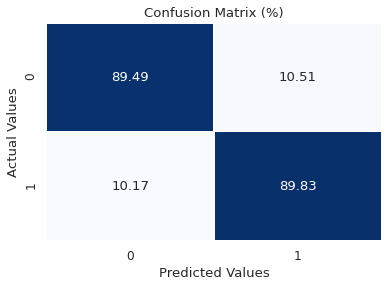

Runtime to fit the model: 0.078 seconds


In [ ]:
# Perform the modeling 
y_train_svm, y_test_svm, score_train, score_test, RunTime = Modeling(X_train_b, X_test_b, y_train_b, y_test_b , 'SVM_Linear', 
                                                                     params_grid = {}, other_params = {}, Scoring = 'matthews_corrcoef', 
                                                                     gridsearch = False)
# Save the Scores 
BinaryScores['Linear_SVM'] = [score_train, score_test]
BinaryRuntime['Linear_SVM'] = RunTime

**Interpretations:** 

> For this trial, we found that the simple linear SVM model provides a score of $76.747\%$ of matthews correlation on the train data and $79.074\%$ on the test data, which is a good performance for a simple model. However, this result is not good enough to properly classify the images. As a solution, we will change the kernel. Actually, we expected this low performance on both training and test data since our problem is non linear and the features overlapped.That is, a linear hyperplan of the SVM model cannot perfectly classify the images.

#### 1.2 Non-Linear Kernel

matthews_corrcoef for SVMModel; in-sample:  70.058 %
matthews_corrcoef for SVMModel; out-of-sample:  73.463 %


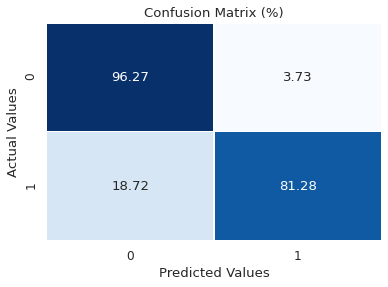

Runtime to fit the model: 0.109 seconds


In [ ]:
# Perform the modeling 
y_train_svm, y_test_svm, score_train, score_test, RunTime = Modeling(X_train_b, X_test_b, y_train_b, y_test_b , 'SVM', 
                                                                     params_grid = {}, other_params = {'kernel' : 'poly'}, 
                                                                     Scoring = 'matthews_corrcoef', gridsearch = False)
# Save the Scores 
BinaryScores['NonLinear_SVM'] = [score_train, score_test]
BinaryRuntime['NoneLinear_SVM'] = RunTime

**Interpretations:**

> When we changed the kernel into a non-linear one, the performance of the model changed to $70.058 \%$ on the train data and $73.463\%$ on the test data. Also, the model is able to well classify the healthy class with a percentage equal to $96.27\%$ and $81.28\%$ for the unhealthy class. These results are good for a simple non-linear model. Indeed, we expected that performance because the model is too simple. To improve these results, we may tune the parameters.

#### 1.3 Look for the Best Model

Best training Score: 92.148 %
Best training params: {'C': 10, 'coef0': 3, 'degree': 4, 'kernel': 'poly'}
matthews_corrcoef for SVMModel; in-sample:  87.737 %
matthews_corrcoef for SVMModel; out-of-sample:  87.743 %


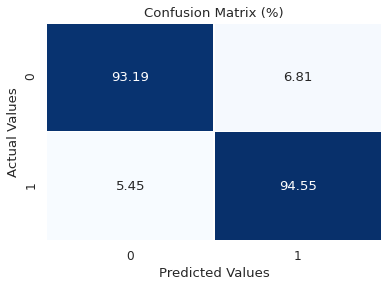

Runtime to fit the model: 15.995 seconds


In [ ]:
# Parameters of GridSearch 
params_grid = {'C': [1e-3,1e-1,1,2,10],
              'degree':[1,2,3,4],
              'coef0':[0,1e-1,1,2,3],
               'kernel':['poly']
               }
other_params = {'C': 0 , 'kernel' : 'linear', 'degree' : 0 , 'coef0': 0 }

# Perform the modeling 
y_train_svm, y_test_svm, score_train, score_test, RunTime , Best = Modeling( X_train_b, X_test_b, y_train_b, y_test_b , 'SVM', 
                                                                   params_grid, other_params, Scoring = 'matthews_corrcoef', gridsearch = True)

# Save the Scores 
BinaryScores['SVM'] = [score_train, score_test]
BinaryRuntime['SVM'] = RunTime

**Interpretations:**

> With the GidSearch method, we notice that the performance improves. This model works great for the binary classification task. That is, the model is reliable and we can use it later in the prediction of the test data. However, the computational time of this model is high. Thus, this is a limit of this algorithm. Indeed, this result is expected because the gridsearch uses all the different combinations of the parameters to train the model and determine the best one that gives the high performances.
<br><br>
$\Longrightarrow$ We should try another algorithm and look for the best performance but with a lower computational time.


### **2. Decision Tree**

#### 2.1 Simple Model

matthews_corrcoef for DecisionTreeModel; in-sample:  100.0 %
matthews_corrcoef for DecisionTreeModel; out-of-sample:  78.688 %


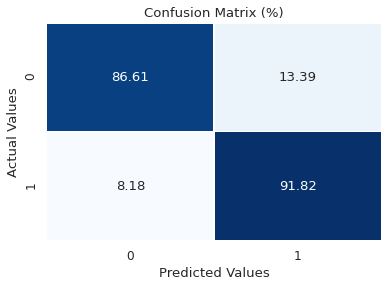

Runtime to fit the model: 0.015 seconds


In [ ]:
# Parameters of GridSearch 
params_grid = {}
other_params = {}

# Perform the modeling 
y_train_svm, y_test_svm, score_train, score_test, RunTime = Modeling( X_train_b, X_test_b, y_train_b, y_test_b, 'DecisionTree', 
                                                                     params_grid, other_params, Scoring = 'matthews_corrcoef', gridsearch = False)

# Save the Scores 
BinaryScores['DecisionTree_simple'] = [score_train, score_test]
BinaryRuntime['DecisionTree_simple'] = RunTime

**Interpretations:**

> From the previous result, we can notice that the model presents an overfitting. There is a huge difference between training and test scores. Therefore, we should add a stop criterion for this model or choose the correct set of hyperparameters. For this, we will use the GridSearch method to find the best set of hyperparameters. 

#### 2.2 Look for the Best Model

Best training Score: 89.532 %
Best training params: {'min_samples_leaf': 1, 'min_samples_split': 6}
matthews_corrcoef for DecisionTreeModel; in-sample:  97.398 %
matthews_corrcoef for DecisionTreeModel; out-of-sample:  78.901 %


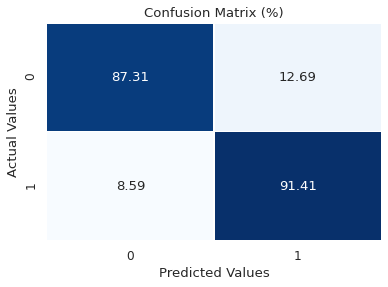

Runtime to fit the model: 1.083 seconds


In [ ]:
# Parameters of GridSearch 
params_grid = {'min_samples_leaf' : range(1,10), 'min_samples_split' : range(1, 7)}
other_params = {}

# Perform the modeling 
y_train_dtc, y_test_dtc, score_train, score_test, RunTime , Best_DT = Modeling(X_train_b, X_test_b, y_train_b, y_test_b, 'DecisionTree', 
                                                                     params_grid, other_params, Scoring = 'matthews_corrcoef', gridsearch = True)

# Save the Scores 
BinaryScores['DecisionTree'] = [score_train, score_test]
BinaryRuntime['DecisionTree'] = RunTime

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  4
The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  14


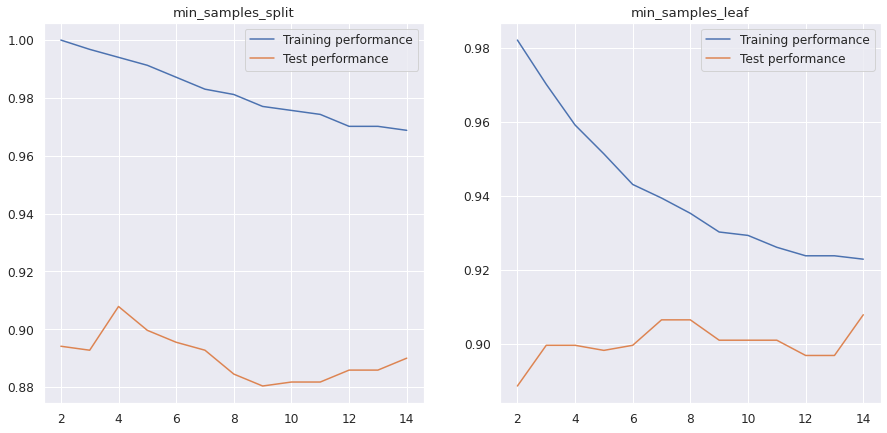

In [ ]:
# Impact of the parameters on the Descion Tree Model
Evaluation (X_train_b, X_test_b, y_train_b, y_test_b , 'DT')

**Interpretations:**

> - While trying to change the min_smaple_split in the decision tree classifier, we found that the best minimum number of samples required to split an internal node is $2$ for the training data and $4$ for the test data. But, we still have an overfitting, i.e. a remarkable difference between the test and train scores.
<br><br>
> - While trying to change the min_samples_leaf, we found that $2$ is the best value that maximizes the train score and $14$ is the best value that maximizes the test score. We notice from these values a huge difference between training and test results.
<br><br>
> - Despite the good performance of the previous model and the reduction of the computational time, the decision tree model still shows an overfitting even when we tried to change the values of the hyperparameters. 
<br><br>
$\Longrightarrow$  Decision trees are prone to overfitting, especially when a tree is particularly deep. This is due to the amount of specificity we look at leading to smaller sample of events. One way to combat this issue is to set a max depth. This will limit our risk of overfitting; but as always, it will be at the expense of error due to bias. Ideally, we would like to minimize both bias error and variance error. Random forests mitigate this problem well. In fact, a random forest is simply a set of decision trees whose results are aggregated into one final result. Their ability to limit overfitting without dramatically increasing bias errors is why they are such powerful models. We will then implement a Random Forest model. 




### **3. Random Forest**

Best training Score: 92.01 %
Best training params: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2000}
matthews_corrcoef for RandomForestModel; in-sample:  97.771 %
matthews_corrcoef for RandomForestModel; out-of-sample:  86.618 %


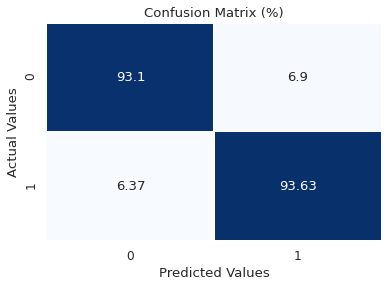

Runtime to fit the model: 196.486 seconds


In [ ]:
# Parameters of GridSearch 
params_grid = {'min_samples_leaf' : range(2, 5), 'n_estimators' : [100,500,1000,2000], 'min_samples_split': range(2, 5)}
other_params = {}

# Perform the modeling 
y_train_rf, y_test_rf, score_train, score_test, RunTime , Best_RF = Modeling(X_train_b, X_test_b, y_train_b, y_test_b, 'RandomForest', 
                                                                          params_grid, other_params, Scoring = 'matthews_corrcoef', 
                                                                          gridsearch = True)

# Save the Scores
BinaryScores['RandomForest'] = [score_train, score_test]
BinaryRuntime['RandomForest'] = RunTime

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  7
The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  3


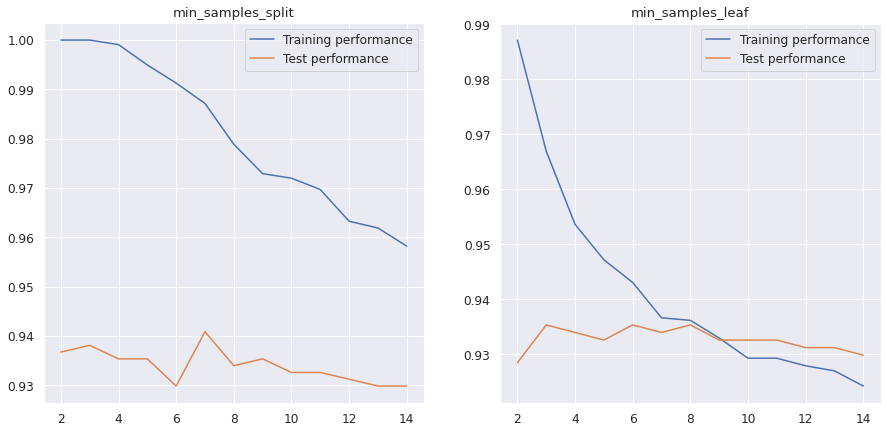

In [ ]:
# Impact of the parameters on the Random Forest Model
Evaluation(X_train_b, X_test_b, y_train_b, y_test_b, 'RF')

**Interpretations:**

> From all the previous results, we can see that the Random Forst model reduce the problem of the overfitting noticed from the descion tree model. In fact, we obtained $97.771 \% $ of matthews correlation on the training data and $86.618 \%$ on the test data. In addition, the min samples split for the best training score is equal to $2$ and min samples leaf is equal to $2$. Indeed, the higher the minimum number of leafs, the higher number of observations in a specific leaf is; hence, the model will not overfit on the training set. However, the runtime to tune the parameters is overwhelming. This parameter tunning results in the increase of the computational time. In the next part, we will study the importance of features and the impact of the models on the boundaries between the features. 

### **4. Feature Imporatance and Boundaries**

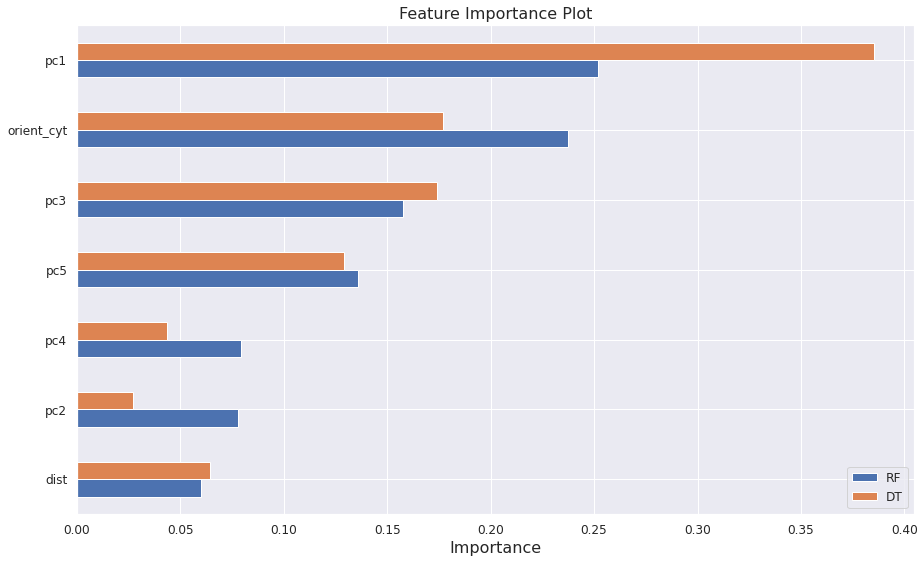

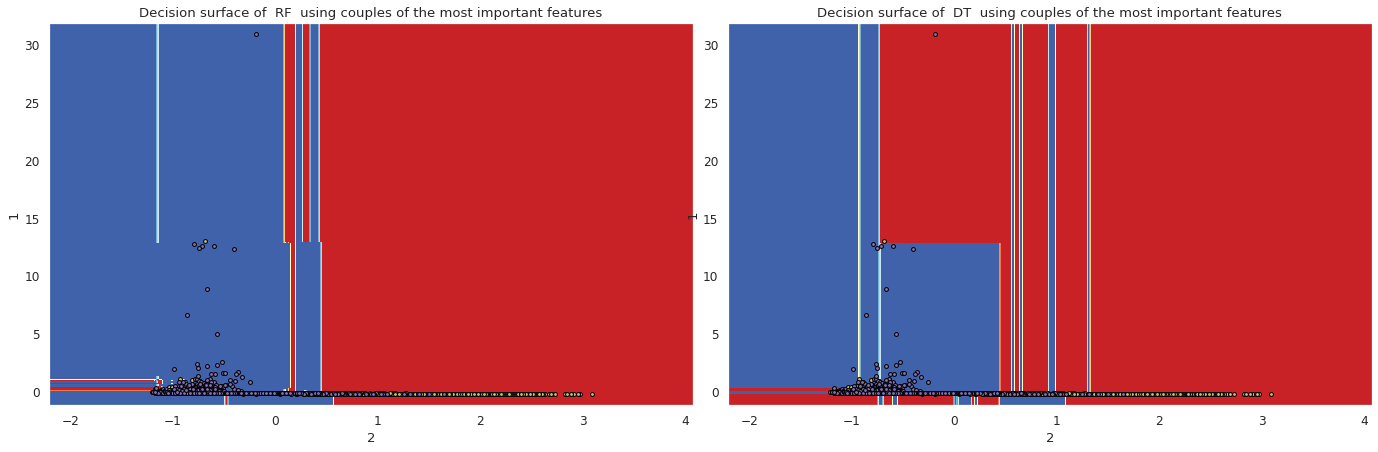

In [ ]:
# Best Model
model1 = RF(**Best_RF)
model2 = DTC(**Best_DT)

# Plot feature importance and boundaries 
Boundaries(model1, model2 , X_train_b, X_test_b, y_train_b, y_test_b )

**Interpretations:**

> - As we can clearly see in the above graph, the decision tree model gives high importance to a particular set of features. But the random forest chooses features randomly during the training process. Therefore, it does not depend highly on any specific set of features. This is a special characteristic of random forest.
<br><br> 
> - Therefore, the random forest can generalize over the data in a better way. This randomized feature selection makes random forest much more accurate than a decision tree.
<br><br> 
> - The best random forest model did not show an overfiting on both features having the best importance. But, the best decsion tree model depicts a high overfit between these same features. 

### **5. Compare Results**

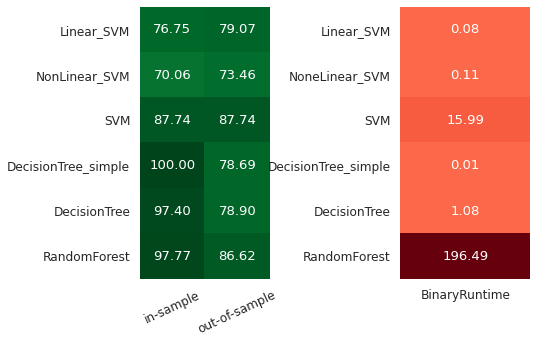

In [ ]:
plt.figure(figsize = (7, 5))

# Plot the heatmap of the scores 
plt.subplot(1,2,1)
sns.heatmap(BinaryScores.T, annot = True, fmt = '.2f', cbar = False, cmap = 'Greens' , center = 0)
plt.xticks(rotation = 25)

# Plot the heatmap of the scores 
plt.subplot(1,2,2)
BinaryRuntime = BinaryRuntime.T
BinaryRuntime['BinaryRuntime'] = BinaryRuntime['BinaryRuntime'].astype(float)
sns.heatmap(BinaryRuntime, annot = True, fmt = '.2f', cbar = False, cmap = 'Reds' , center = 0)
plt.subplots_adjust(wspace = 1)
plt.show()

**Interpretations:**

> Broadly, the RandomForest and the SVM results provide the highest out of sample performance. On top of that, they depict low difference between the out of sample and the in sample performances. However, the runtime of the Random Forest model is too high when comparing to the other models. In addition, the decision tree model provides good results and a low computational time but as we noticed before, it suffers from the overfiting problem. 

## **Machine Learning Classification Models for MultiClass Data**

**In this part, we will try to build and look for the best model that gives us the higher performances. In this case, we will work on a mulitclass task. We will follow the same reasoning as for the binary classification.**

In [ ]:
# Initialize dataframes to save the performances 
MultiScores = pd.DataFrame(index = ['in-sample' , 'out-of-sample'])
MultiRuntime = pd.DataFrame(index = ['MultiRuntime'])

### **1. SVM**

#### 1.1 Linear Kernel

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy for SVM_LinearModel; in-sample:  64.088 %
accuracy for SVM_LinearModel; out-of-sample:  73.865 %


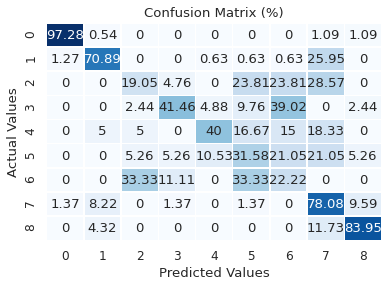

Runtime to fit the model: 0.769 seconds


In [ ]:
# Perform the modeling 
y_train_svm, y_test_svm, score_train, score_test, RunTime = Modeling( X_train_m, X_test_m, y_train_m, y_test_m , 'SVM_Linear', 
                                                                     params_grid = {}, other_params = {}, Scoring = 'accuracy', gridsearch = False)
# Save the Scores 
MultiScores['Linear_SVM'] = [score_train, score_test]
MultiRuntime['Linear_SVM'] = RunTime

**Interpretations:**

> We notice that the performance of this SVM linear model is too low. In fact, the model is simple to classify well the clases which initially present a small quantity of images. This was actually expected even though we added data balancing method on these unbalanced classes in order to make the data balanced. This method is based on the bootstrap technique. However, the duplicated samples will not add too much information for the models when compared to the classes {0,1,7,8}. That's why, I think all these models will perform much better for these classes. In the next step, we will follow the same strategy as in the previous part and see if or not the performance changes by trying to make a compromise between performance and computational time. 

#### 1.2 Non-Linear Kernel

accuracy for SVMModel; in-sample:  59.224 %
accuracy for SVMModel; out-of-sample:  66.85 %


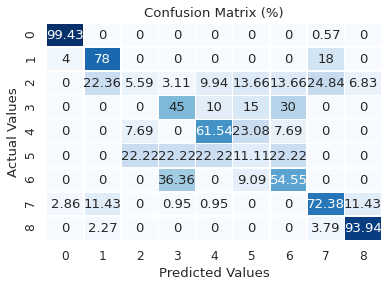

Runtime to fit the model: 0.483 seconds


In [ ]:
# Perform the modeling 
y_train_svm, y_test_svm, score_train, score_test, RunTime = Modeling( X_train_m, X_test_m, y_train_m, y_test_m, 'SVM', 
                                                                     {}, other_params = {'kernel' : 'poly'}, Scoring = 'accuracy', gridsearch = False)
# Save the Scores 
MultiScores['NonLinear_SVM'] = [score_train, score_test]
MultiRuntime['NonLinear_SVM'] = RunTime

**Interpretations:**

> As we expected, using a non-linear kernel for SVM, the performances changed especially on the unbalanced classes. For exampple, for the fifth class, the performance has improved from $40 \%$ to $61.54 \%$. Our aim now is to improve this previous performance by applying the gridsearch method to tune the parameters.

#### 1.3 Find the Best Model

Best training Score: 83.468 %
Best training params: {'C': 10, 'coef0': 3, 'degree': 4, 'kernel': 'poly'}
accuracy for SVMModel; in-sample:  85.938 %
accuracy for SVMModel; out-of-sample:  80.193 %


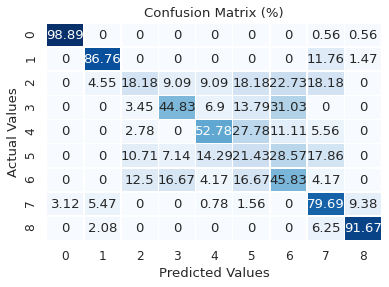

Runtime to fit the model: 54.695 seconds


In [ ]:
# Parameters of GridSearch 
params_grid = {'C': [1e-3,1e-1,1,2,10],
              'degree':[1,2,3,4],
              'coef0':[0,1e-1,1,2,3],
               'kernel':['poly']
               }
other_params = {'C': 0 , 'kernel' : 'linear', 'degree' : 0 , 'coef0': 0 , 'decision_function_shape' : 'ovr' }

# Perform the modeling 
y_train_svm, y_test_svm, score_train, score_test, RunTime , Best = Modeling(X_train_m, X_test_m, y_train_m, y_test_m, 'SVM', 
                                                                     params_grid, other_params, Scoring = 'accuracy', gridsearch = True)

# Save the Scores 
MultiScores['SVM'] = [score_train, score_test]
MultiRuntime['SVM'] = RunTime

**Interpretations:**

> It is clear that the performance increased from both prior models. The classification rank for the unbalanced classes has increased. The gridsearch, as expected, improves the models' perforances by looking for the best parameters in an effetient way. In addition, the model gives $85.938 \%$ accuracy on the training data and $80.193 \%$ on the test data which is considered a great classification result for the multiclass classification task. In addition, the computational time is higher than the simple model which is expected. Next, we will try the decision tree and see if the performance increases when the computational time deceases. 



### **2. Decision Tree**

#### 2.1 Simple Model

accuracy for DecisionTreeModel; in-sample:  100.0 %
accuracy for DecisionTreeModel; out-of-sample:  71.252 %


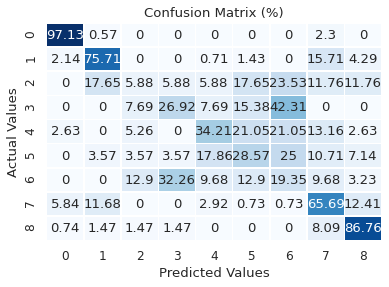

Runtime to fit the model: 0.031 seconds


In [ ]:
# Perform the modeling 
y_train_svm, y_test_svm, score_train, score_test, RunTime = Modeling(X_train_m, X_test_m, y_train_m, y_test_m, 'DecisionTree', 
                                                                     {}, {}, Scoring = 'accuracy', gridsearch = False)

# Save the Scores 
MultiScores['DecisionTree_simple'] = [score_train, score_test]
MultiRuntime['DecisionTree_simple'] = RunTime

**Interpretations:**

> Again, the Decision Tree model depicts a high overfitting where the in-sample performance is $100 \%$ but the out of sample performance is $71.252 \%$. Thus, it is worth to tune the parameters.

#### 2.2 Parameter Tunning

Best training Score: 91.305 %
Best training params: {'min_samples_leaf': 2, 'min_samples_split': 2}
accuracy for DecisionTreeModel; in-sample:  97.959 %
accuracy for DecisionTreeModel; out-of-sample:  74.14 %


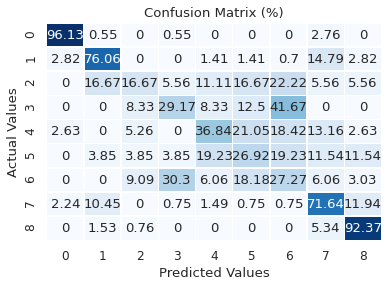

Runtime to fit the model: 1.802 seconds


In [ ]:
# Parameters of GridSearch 
params_grid = {'min_samples_leaf' : range(1,10), 'min_samples_split' : range(1, 7)}
other_params = {}

# Perform the modeling 
y_train_dtc, y_test_dtc, score_train, score_test, RunTime , Best_DT = Modeling(X_train_m, X_test_m, y_train_m, y_test_m, 'DecisionTree', 
                                                                     params_grid, other_params, Scoring = 'accuracy', gridsearch = True)

# Save the Scores 
MultiScores['DecisionTree'] = [score_train, score_test]
MultiRuntime['DecisionTree'] = RunTime

**Interpretations:**

> Now, we notice that we managed to reduce a little bit the overfitting. However, there is no high increase in the out of sample performance. In fact, it passes from $71.252 \%$ to $74.14 \%$. In addition, this model do not perform well on the unbalanced classes. 

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  4
The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  2


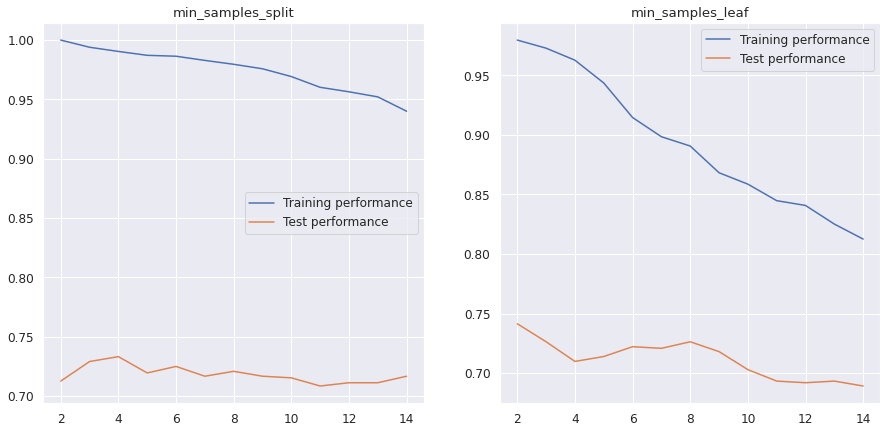

In [ ]:
# Impact of the parameters on the Descion Tree Model
Evaluation(X_train_m, X_test_m, y_train_m, y_test_m, 'DT')

**Interpretations:**

> - As we mentioned in the binary problem, the higher the min_samples_split and min_samples_leaf, the lower the overfitting is.
<br><br> 
> - The values of the min sample split and the min sample leaf are low for the best training and testing scores, that's why we have earlier obtained an overfit which is expected since these values are too small. 
<br><br> 
> - As we mentioned before the random forest reduces the overfitting of the decision tree models. Thus, we will see if this model manage to well classify the data with the bootstrap method on the unbalanced classes. 

### **3. Random Forest**

Best training Score: 94.38 %
Best training params: {'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1000}
accuracy for RandomForestModel; in-sample:  99.294 %
accuracy for RandomForestModel; out-of-sample:  79.78 %


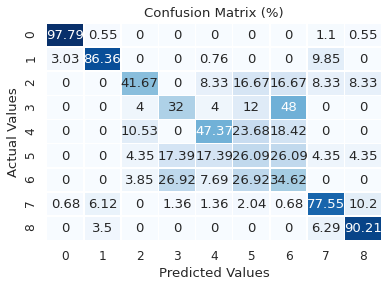

Runtime to fit the model: 314.34 seconds


In [ ]:
# Parameters of GridSearch 
params_grid = {'min_samples_leaf' : range(2, 5), 'n_estimators' : [100,500,1000,2000], 'min_samples_split': range(2, 5)}
other_params = {}

# Perform the modeling 
y_train_rf, y_test_rf, score_train, score_test, RunTime , Best_RF = Modeling(X_train_m, X_test_m, y_train_m, y_test_m, 'RandomForest', 
                                                                     params_grid, other_params, Scoring = 'accuracy', gridsearch = True)

# Save the Scores
MultiScores['RandomForest'] = [score_train, score_test]
MultiRuntime['RandomForest'] = RunTime

The value of min_samples_split that maximizes the training score is :  2
The value of min_samples_split that maximizes the test score is :  2
The value of min_samples_leaf that maximizes the training score is :  2
The value of min_samples_leaf that maximizes the test score is :  3


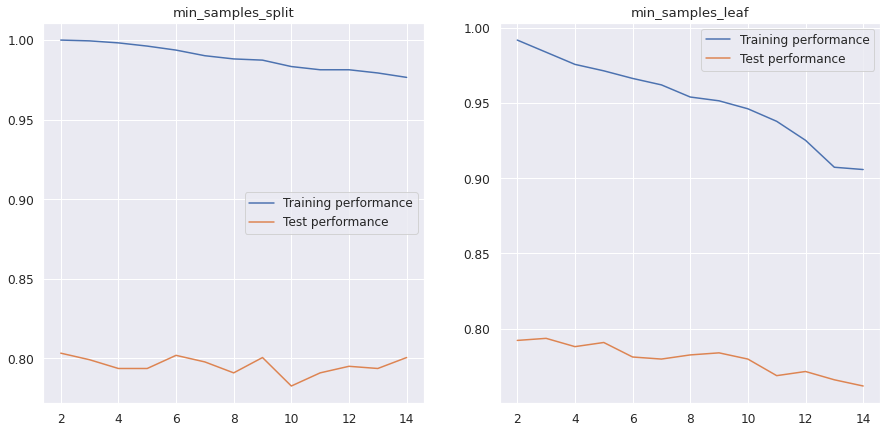

In [ ]:
# Impact of the parameters on the Random Forest Model
Evaluation(X_train_m, X_test_m, y_train_m, y_test_m, 'RF')

**Interpretations:**

> The result of Random Forest model is not as expected. Actually, the performance of this model decreased and the model could not reduce the overfitting impact. We can notice also that the min sample split and the min samples leaf for both traning and test scores are still low, which will provide a lower performance. However, this model achieves higher classification percentages for the unbalanced classes which is an improvement from the decision tree model. 

### **4. Feature Imporatance and Boundaries** 

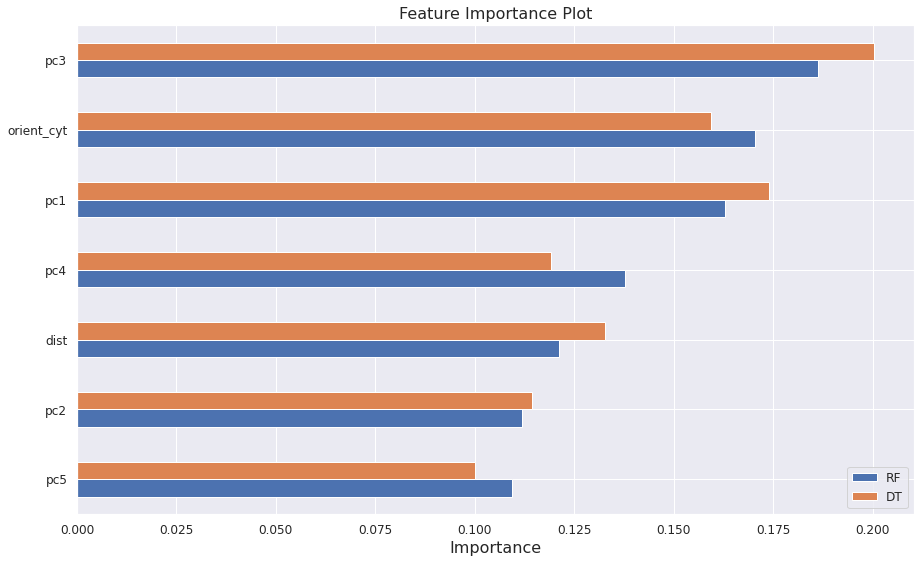

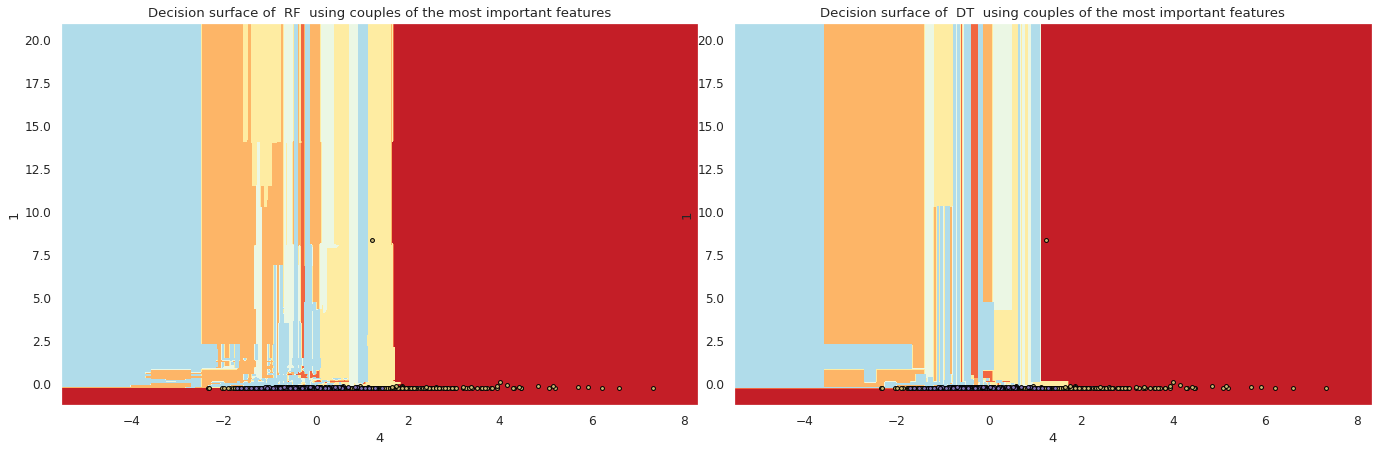

In [ ]:
# Best Model
model11 = RF(**Best_RF)
model22 = DTC(**Best_DT)

# Plot feature importance and boundaries 
Boundaries(model11, model22 , X_train_m, X_test_m, y_train_m, y_test_m)

**Interpretations:**
> - Both models show an overfitting. Howerver, for the Random forest model, the overfit is less than the decision tree model. This result is seen from the boundaries plot of the two features that shows the highest importance for the Random Forest model. 
<br><br> 
> - As the previous results, the decision tree model puts a great importance on a particular set of features. But, the Random Forest chooses the features randomly during the training process, which was noticed from the feature importance plot. 





### **5. Compare Results**

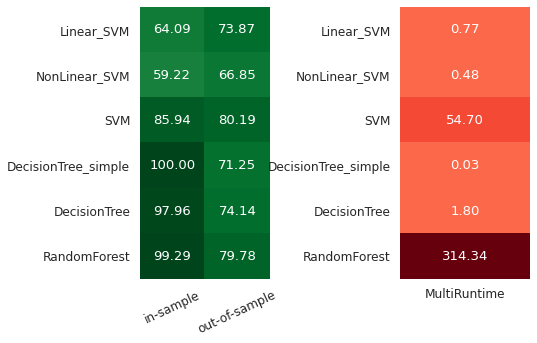

In [ ]:
plt.figure(figsize = (7, 5))

# Plot the heatmap of the scores 
plt.subplot(1,2,1)
sns.heatmap(MultiScores.T, annot = True, fmt = '.2f', cbar = False, cmap = 'Greens' , center = 0)
plt.xticks(rotation = 25)

# Plot the heatmap of the scores 
plt.subplot(1,2,2)
MultiRuntime = MultiRuntime.T
MultiRuntime['MultiRuntime'] = MultiRuntime['MultiRuntime'].astype(float)
sns.heatmap(MultiRuntime, annot = True, fmt = '.2f', cbar = False, cmap = 'Reds' , center = 0)
plt.subplots_adjust(wspace = 1)
plt.show()

**Interpretations:**

> The SVM model gives a great performance. There is no difference between the in-sample and out-of-samlpe scores. However, it has a high computational time. Moreover, the Simple decision tree, the decision tree and the random forest models show an overfit by the huge difference between the in-sample and out-of-sample scores. In addition, the random forest and the SVM have a high computational time which is due to the gridsearch method. 

## **Prepare Images for Deep Learning Task**

> - **In this part, we aim to improve the previous classification results. That's why, we will use a deep learning model for both classification problems (binary and multiclass classification). For the pre-processing step, I suggest not to use the original images. Thus, we will only leave the region of the cell in the image which is the ROI in this problem. This cropped image helps the model to focus on the region of the cell and ignore the regions around the cell as they are confusing.**
<br><br>
> - **For the Data augmentation step, we will create a data generator. This data generator is able to read rapidly the data and at the same time perform data augmentation (rotation, width shift, height shift, shear, zoom, horizental flip). This data generator rescale also the images. Actually, the rescale is mondatory since we need scaled images as input for the deep learning model. In addition, this generator requires separate classes. Therefore, we will start by dividing the train and validation data into folders for each class. Then, the generator accesses to the folder and imports the data.**

### 1. Binary Data 


In [ ]:
##### Create a data generator. 
##### This generator is used to facilitate the importation 
##### of the data and to perform a data augmentation based 
##### on different parameters written below

train_datagen_binary = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

##### Import the train dataset, this train_generator is able 
##### to differentiate between the two classes 0 and 1 imported 
##### from both folders created above

train_generator_binary = train_datagen_binary.flow_from_directory(
    PathTo + '/Binary/Data_masked/Train/', 
    subset = 'training',
    seed = 0)

##### Import the validation dataset, this val_generator is able 
##### to differentiate between the two classes 0 and 1 imported 
##### from both folders created above

val_generator_binary = train_datagen_binary.flow_from_directory(
    PathTo + '/Binary/Data_masked/Val/', 
    subset = 'training',
    seed = 0)

Found 2000 images belonging to 2 classes.
Found 921 images belonging to 2 classes.


### 2. MultiClass Data

In [ ]:
##### Create a data generator. 
##### This generator is used to facilitate the importation 
##### of the data and to perform a data augmentation based 
##### on different parameters written below

train_datagen_multi = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

##### Import the train dataset, this train_generator is able 
##### to differentiate between the classes imported 
##### from both folders created above

train_generator_multi = train_datagen_multi.flow_from_directory(
    PathTo + '/Multi/Data_masked/Train/', 
    subset = 'training',
    seed = 0)

##### Import the validation dataset, this val_generator is able 
##### to differentiate between classes imported 
##### from both folders created above

val_generator_multi = train_datagen_multi.flow_from_directory(
    PathTo + '/Multi/Data_masked/Val/',
    subset = 'training',
    seed = 0)

Found 2049 images belonging to 9 classes.
Found 872 images belonging to 9 classes.


## **Deep Learning Classification Model for Binary Classification**

**In this part, we will try out different models and architectures and submit them in order to get the best model that predicts well the classes. The image below shows the process of our deep learning model. The training stage is based on preparing the data and building the model in order to fit it on the data. The created model will then be used to predict the test data.**  

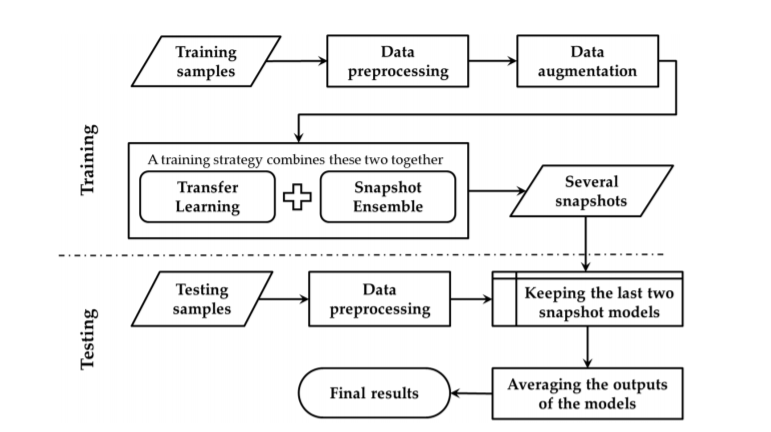

### 1. Create the Model

> For the binary classification, we have chosen the EfficientNetB2 model and noisy-student to initialize the weights. In fact, this choice is based on a study carried out in the paper: **Self-training with Noisy Student improves ImageNet classification** for the authors [Qizhe Xie, Minh-Thang Luong et al.].
https://arxiv.org/pdf/1911.04252.pdf .
<br> <br> 
In this paper, they highlighted that the EfficientNet pre-trained model trained using the previous weights generated from the teacher model gives better results for the classification task. In addition, I discoverd that this initialization is more robust than ImageNet. 
<br> <br> 
> Here, for the binary classification task, we will use the binary crossentropy as loss function and Adam as optimizer with a learning rate equal to $0.0001$. For the evaluation, we will use the mathews correlation.


In [ ]:
##### Create the base model
base_model =  efn.EfficientNetB2(include_top=False, weights='noisy-student',input_shape=(256,256,3))

##### Design the architecture of the model 
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = Dense(512,activation=('relu'))(x)
x = BatchNormalization()(x) 
x = Dropout(0.5)(x)

x = Dense(192, activation=('relu'))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation=('relu'))(x)
x = BatchNormalization()(x)

predictions = Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

##### Compile the model
model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=[matthews_correlation])

31784960/31782304 [==============================] - 0s 0us/step


In [ ]:
##### Parameters of the model 
batch_size = 64
initial_epochs = 30

##### Fit the model
history = model.fit(train_generator_binary, 
                    batch_size=batch_size,
                    epochs=initial_epochs,
                    validation_data=val_generator_binary)

Epoch 1/30
63/63 [==============================] - 72s 710ms/step - loss: 0.7520 - matthews_correlation: 0.2484 - val_loss: 0.6451 - val_matthews_correlation: 0.5146
Epoch 2/30
63/63 [==============================] - 42s 670ms/step - loss: 0.4293 - matthews_correlation: 0.6998 - val_loss: 0.5586 - val_matthews_correlation: 0.5887
Epoch 3/30
63/63 [==============================] - 42s 663ms/step - loss: 0.3187 - matthews_correlation: 0.8181 - val_loss: 0.4297 - val_matthews_correlation: 0.7072
Epoch 4/30
63/63 [==============================] - 42s 662ms/step - loss: 0.2395 - matthews_correlation: 0.8549 - val_loss: 0.2799 - val_matthews_correlation: 0.8350
Epoch 5/30
63/63 [==============================] - 42s 661ms/step - loss: 0.2269 - matthews_correlation: 0.8408 - val_loss: 0.2061 - val_matthews_correlation: 0.8861
Epoch 6/30
63/63 [==============================] - 42s 664ms/step - loss: 0.2239 - matthews_correlation: 0.8532 - val_loss: 0.1522 - val_matthews_correlation: 0.910

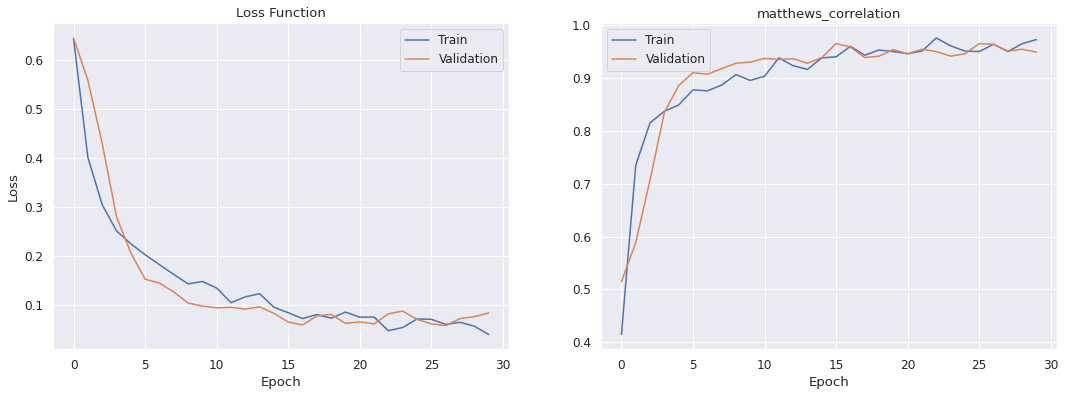

In [ ]:
##### Plot the loss and matthews correlation curves in function of epochs

##### The loss plot
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True);
plt.legend()

##### The matthews correlation curves
plt.subplot(122)
plt.plot(history.history['matthews_correlation'], label='Train')
plt.plot(history.history['val_matthews_correlation'], label = 'Validation')
plt.title('matthews_correlation')
plt.xlabel('Epoch')
plt.grid(True);
plt.legend()

plt.show()

**Interpretations:**

> - As we can see from the plot of the loss function, the train and validation curves decrease until they achieve values almost equal to $0.04$ for the training dataset and $0.08$ for the validation dataset. These values are very close and the curves almost coincide. In addition, the matthew's correlation curves increase. They reach values above $95 \%$. 
<br><br>
> - These performances are very reliable and this model is able to well classify both classes. This performance is actually related to the initial weights which they helped very well the model to train on the new dataset. Moreover, parameter tuning and regularization (dropout and batch normalization) helped the model to improve and succeed to avoid the overfitting problem.

### 2. Make predictions 

In [ ]:
# Plot the confusion matrix and performances 

Class = 'ABNORMAL'
#train_pred = Predict(train_generator_binary, model, Class, Classes)
#val_pred = Predict(val_generator_binary, model, Class, Classes)
#Evaluation_DL(train_pred, val_pred, Class, 'matthews_corrcoef')

predicted_data = SaveSubmission(OriginalPath, PathTo, Class, model, Classes)

### 3. Plot Some Images 

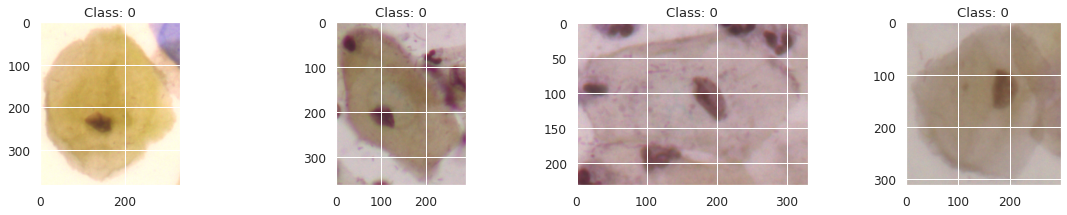

In [ ]:
# Plot Some images 
nbr_img = 4

# Predicted images 
mis_imgs = val_pred.loc[val_pred['Predict'] != val_pred[Class]].index[:nbr_img].astype(str)

# Import images 
PathTrain = OriginalPath + 'Train/'

# Plot images 
plt.figure(figsize = (20, 3))
for i in range(nbr_img):
  plt.subplot(1, nbr_img, i + 1)
  im = cv2.imread(PathTrain + mis_imgs[i] + '.bmp')
  plt.title('Class: ' + str(val_pred.loc[int(mis_imgs[i]) , Class]))
  plt.imshow(im)

**Comment:**

>  These are some missed images from the previous model.

## **Deep Learning Classification Model for Multiclass Classification**

**In this part, we will try different models and architectures and submit them in order to obtain the best model that predicts well the classes. Actually, this multiclass classification problem is more difficult than the previous one since the data is unbalanced. Howerver, we have chosen for the training part the weighted accuracy metric which will take into consideration the data imbalance to show the performance of the model.**  

### 1. Create the model 

> For the MultiClass classification, we have chosen the EfficientNetB0 model and ImageNet dataset to initialize the weights. 
<br><br>
> Here, for the MultiClass classification, we will use the categorical crossentropy as loss function and Adam as optimizer with a learning rate equal to $0.0001$. For the evaluation, we will use the weighted accuracy metric.

In [ ]:
##### Create the base model
base_model =  efn.EfficientNetB0 (include_top=False, weights='imagenet',input_shape=(256,256,3))

##### Design the architecture of the model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = Dense(512,activation=('relu'))(x)
x = Dropout(0.5)(x)

x = Dense(64,activation=('relu'))(x)
x = Dropout(0.5)(x)

predictions = Dense(9, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

##### Compile the model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
                weighted_metrics=['accuracy'])

In [ ]:
##### Parameters of the model
batch_size = 50
initial_epochs = 30 

##### Fit the model
history = model.fit(train_generator_multi, 
                    batch_size=batch_size,
                    epochs=initial_epochs,
                    validation_data=val_generator_multi )

Epoch 1/30
65/65 [==============================] - 65s 851ms/step - loss: 1.9461 - accuracy: 0.2842 - val_loss: 1.7031 - val_accuracy: 0.4071
Epoch 2/30
65/65 [==============================] - 53s 820ms/step - loss: 1.0277 - accuracy: 0.6503 - val_loss: 1.2895 - val_accuracy: 0.6158
Epoch 3/30
65/65 [==============================] - 54s 824ms/step - loss: 0.7637 - accuracy: 0.7373 - val_loss: 0.9546 - val_accuracy: 0.7076
Epoch 4/30
65/65 [==============================] - 53s 812ms/step - loss: 0.6087 - accuracy: 0.8001 - val_loss: 0.7135 - val_accuracy: 0.7592
Epoch 5/30
65/65 [==============================] - 53s 819ms/step - loss: 0.5610 - accuracy: 0.8113 - val_loss: 0.6151 - val_accuracy: 0.7947
Epoch 6/30
65/65 [==============================] - 55s 839ms/step - loss: 0.4884 - accuracy: 0.8332 - val_loss: 0.5027 - val_accuracy: 0.8257
Epoch 7/30
65/65 [==============================] - 54s 827ms/step - loss: 0.4638 - accuracy: 0.8494 - val_loss: 0.4740 - val_accuracy: 0.8326

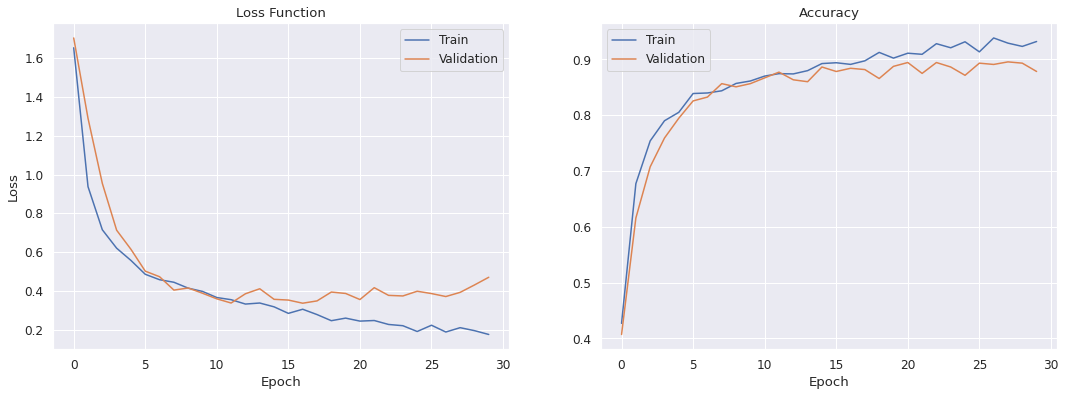

In [ ]:
##### Plot the loss and matthews correlation curves in function of epochs
plt.figure(figsize=(18,6))

##### The loss plot
plt.subplot(121)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True);
plt.legend()

##### The matthews correlation curves
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.grid(True);
plt.legend()

plt.show()

**Interpretations:**

> - The loss function curves increase along the epochs. At the beginning, the validation curve has values higher than the training losses. But, the two plots are very close. In the end, these plots start to seperate from each other. 
<br><br> 
> - For the weighted accuracy, the curves increase. The values are very close. The train accuracy achieved $93 \%$ and the validation accuracy converges to $89 \%$. 
<br><br> 
$\Longrightarrow$ This model gives the best classification performance. It has very good predictions results which are improved from the previous machine learning models. 

### 2. Make predictions 

In [ ]:
# Plot the confusion matrix and performances 

Class = 'GROUP'
#train_pred = Predict(train_generator_multi, model, Class, Classes)
#val_pred = Predict(val_generator_multi, model, Class, Classes)
#Evaluation_DL(train_pred, val_pred, Class, 'Accuracy')

predicted_data = SaveSubmission(OriginalPath, PathTo, Class, model, Classes)

### 3. Plot Some Images

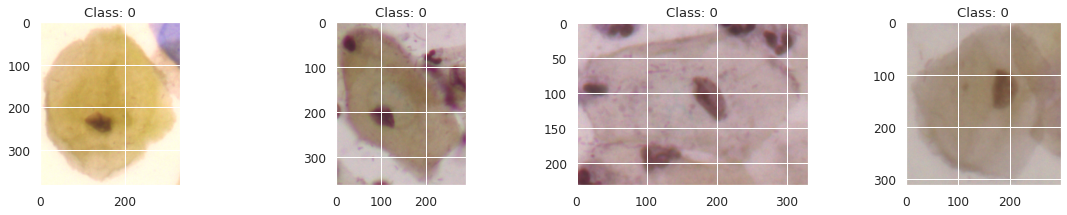

In [ ]:
# Plot Some images 
nbr_img = 4

# Predicted images 
mis_imgs = val_pred.loc[val_pred['Predict'] != val_pred[Class]].index[:nbr_img].astype(str)

# Import images 
PathTrain = OriginalPath + 'Train/'

# Plot images 
plt.figure(figsize = (20, 3))
for i in range(nbr_img):
  plt.subplot(1, nbr_img, i + 1)
  im = cv2.imread(PathTrain + mis_imgs[i] + '.bmp')
  plt.title('Class: ' + str(val_pred.loc[int(mis_imgs[i]) , Class]))
  plt.imshow(im)

**Comment:**

>  These are some missed images from the previous model.

In [ ]:
endRun = time.time() - startRun
print('Total Runtime = ', str(round(endRun, 2)) + ' seconds')

Total Runtime =  8351.11 seconds


## **Conclusion**

To conclude, we have studied during this project how to classify Pap smear cells using different classification techniques. In the first part, we tried to create machine learning models fitted on a dataset generated from the images. This step requires feature extraction by inspecting patterns in the cells. That is, we explored different information provided by the images. After performing the models, we find out that all these models have a good side and limits on performance.
<br><br>
In this project, we were not restricted on the binary classification but also, we studied the multiclass classification. We completed this project by building deep learning models using a pre-trained architecture as an initialization for the weights. Thus, these models perform better than the conventional machine learning techniques.
<br><br>
To sum up, we have performed several methods of preprocessing and postprocessing of the data, we implemented feature extraction and created several classification models in order to study their performance. We have found that deep learning always gives the best results. That is, in traditional machine learning techniques, most of the applied features must be identified by an expert in the field in order to reduce data complexity and make models more visible to learning algorithms. In contrast, the biggest advantage of deep learning algorithms is that they try to learn high-level functionality from data incrementally. This eliminates the need for domain expertise and core functionality extraction.